In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
!pip uninstall -y peft accelerate
!pip install numpy==1.26.4 accelerate==0.27.2

Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
  Using cached accelerate-0.27.2-py3-none-any.whl.metadata (18 kB)
Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)


In [2]:
import accelerate
import transformers

print("Accelerate:", accelerate.__version__)
print("Transformers:", transformers.__version__)

Accelerate: 0.27.2
Transformers: 4.38.2


In [3]:
!pip uninstall -y torch torchvision torchaudio transformers datasets evaluate
!pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2
!pip install transformers==4.38.2 datasets accelerate evaluate scikit-learn

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0
Found existing installation: datasets 4.4.1
Uninstalling datasets-4.4.1:
  Successfully uninstalled datasets-4.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [3]:
import sys
import torch
import transformers

print("Python:", sys.version)
print("Torch:", torch.__version__)
print("Transformers:", transformers.__version__)
print("CUDA Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", torch.cuda.get_device_properties(0).total_memory / 1e9)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch: 2.2.2+cu121
Transformers: 4.38.2
CUDA Available: True
GPU: Tesla P100-PCIE-16GB
VRAM (GB): 17.059545088


In [9]:
from datasets import load_dataset

DATASET_NAME = "amazon_polarity"
TRAIN_SAMPLES = 75000
VAL_SAMPLES = 2000

dataset = load_dataset(DATASET_NAME)

dataset = dataset.shuffle(seed=42)

train_dataset = dataset["train"].select(range(TRAIN_SAMPLES))
val_dataset = dataset["test"].select(range(VAL_SAMPLES))

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print(train_dataset[0])

Train size: 75000
Validation size: 2000
{'label': 0, 'title': 'Anyone who likes this better than the Pekinpah is a moron.', 'content': "All the pretty people in this film. Even the Rudy character played by Michael Madsen. This is adapted from a Jim Thompson novel for cryin' out loud! These are supposed to be marginal characters, not fashion models. Though McQueen and McGraw were attractive (but check out McQueen's crummy prison haircut) they were believable in the role. Baldwin and Bassinger seem like movie stars trying to act like hard cases. Action wise, the robbery scene in the Pekinpah version was about 100 times more exciting and suspenseful than anything in this re-make."}


In [5]:
set(dataset['train']['label_text'])

{'negative', 'positive'}

In [10]:
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 256

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(batch):
    texts = [
        t + " " + c
        for t, c in zip(batch["title"], batch["content"])
    ]
    
    return tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

train_dataset = train_dataset.map(
    tokenize_batch,
    batched=True,
    num_proc=4
)

val_dataset = val_dataset.map(
    tokenize_batch,
    batched=True,
    num_proc=4
)

# Remove unused columns
train_dataset = train_dataset.remove_columns(["title", "content"])
val_dataset = val_dataset.remove_columns(["title", "content"])

# Convert to torch tensors
train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

print(train_dataset)

Map (num_proc=4):   0%|          | 0/75000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 75000
})


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

NUM_LABELS = 2

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

training_args = TrainingArguments(
    output_dir="./sentiment_distilbert",
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_steps=200,
    eval_steps=2000,
    save_steps=2000,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
2000,0.151900,0.143843,0.949500,0.950995
4000,0.099400,0.147453,0.952000,0.952616


TrainOutput(global_step=4688, training_loss=0.15408004733889583, metrics={'train_runtime': 1814.3746, 'train_samples_per_second': 82.673, 'train_steps_per_second': 2.584, 'total_flos': 9935054899200000.0, 'train_loss': 0.15408004733889583, 'epoch': 2.0})

In [21]:
import numpy as np

print("Running predictions on validation set...")

predictions_output = trainer.predict(val_dataset)

logits = predictions_output.predictions
true_labels = predictions_output.label_ids

pred_labels = np.argmax(logits, axis=1)

print("Prediction completed.")
print("Logits shape:", logits.shape)
print("Labels shape:", true_labels.shape)

Running predictions on validation set...


Prediction completed.
Logits shape: (2000, 2)
Labels shape: (2000,)


In [23]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Negative", "Positive"]))

Validation Accuracy: 0.9520
Validation F1 Score: 0.9526

Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.96      0.95       982
    Positive       0.96      0.95      0.95      1018

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



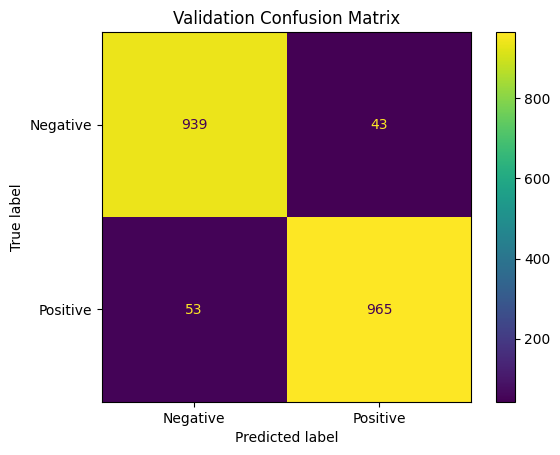

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Negative", "Positive"]
)

disp.plot()
plt.title("Validation Confusion Matrix")
plt.show()

In [27]:
import random

num_samples = 5
indices = random.sample(range(len(val_dataset)), num_samples)

for idx in indices:
    sample = val_dataset[idx]
    
    text = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
    true_label = "Positive" if sample["label"] == 1 else "Negative"
    pred_label = "Positive" if pred_labels[idx] == 1 else "Negative"

    print("=" * 120)
    print("TEXT:")
    print(text[:800], "...")
    print("\nTRUE LABEL:", true_label)
    print("PREDICTED:", pred_label)


TEXT:
bad clutch today 5 / 24 i'm returning my 4th drill in a month due to the cheap clutch dewalt uses in this drill. my old dewalt lasted 7 years and a complete home remodel before giving up. ...

TRUE LABEL: Negative
PREDICTED: Negative
TEXT:
leather conditioner is a must the leather magic nubuck conditioner. oh, wow this stuff is good. i used it on a very thirsty sad tano bag, and it rejuvenated the bag instantly. it also conditioned two pairs of frye boots perfectly, without leaving a shiny finish. i can see this conditioner working on a wide range of leather, washed leather, & suede products quite nicely. the other products from the nubuck kit didn't impress me as much. the cleaner didn't do much to help me with my current lp bag issue, brought on from using leather honey, but it may work well with a lighter requirement or suede products. the ink stain remover is quite strong, and actually stained my bag. i only used it on a small area were the ink is prevalent and washed it away

In [25]:
import torch

def predict_sentiment(text: str):
    model.eval()
    
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(model.device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    
    label = "Positive" if pred == 1 else "Negative"
    confidence = probs[0][pred].item()
    
    return label, confidence


# Example
text = "This product is amazing. Battery life is outstanding and build quality is premium."
label, confidence = predict_sentiment(text)

print("Prediction:", label)
print("Confidence:", round(confidence, 4))

Prediction: Positive
Confidence: 0.9971


In [13]:
trainer.save_model("./sentiment_distilbert/best")
tokenizer.save_pretrained("./sentiment_distilbert/best")

('./sentiment_distilbert/best/tokenizer_config.json',
 './sentiment_distilbert/best/special_tokens_map.json',
 './sentiment_distilbert/best/vocab.txt',
 './sentiment_distilbert/best/added_tokens.json',
 './sentiment_distilbert/best/tokenizer.json')

In [14]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

pipe = pipeline(
    "text-classification",
    model="./sentiment_distilbert/best",
    tokenizer="./sentiment_distilbert/best",
    device=device
)

tests = [
    "This product is amazing and works perfectly!",
    "Worst purchase ever. Totally disappointed.",
    "Packaging was okay but delivery was late."
]

for text in tests:
    print(text)
    print(pipe(text))
    print("-" * 80)

This product is amazing and works perfectly!
[{'label': 'LABEL_1', 'score': 0.9974772334098816}]
--------------------------------------------------------------------------------
Worst purchase ever. Totally disappointed.
[{'label': 'LABEL_0', 'score': 0.998618483543396}]
--------------------------------------------------------------------------------
Packaging was okay but delivery was late.
[{'label': 'LABEL_0', 'score': 0.8361477255821228}]
--------------------------------------------------------------------------------
